# Практическая работа №5: Элементы регрессионного анализа. Выборочные прямые среднеквадратической регрессии. Корреляционное отношение

Выполнил студент гр. 9372 Аксёнов Александр, вариант 2.

## Цель работы
Ознакомление с основными положениями метода наименьших квадратов
(МНК), со статистическими свойствами МНК оценок, с понятием функции регрессии и роли МНК в регрессионном анализе, с корреляционным
отношением, как мерой тесноты произвольной (в том числе и линейной)
корреляционной связи.



## Основные теоретические положения
**Уравнение регрессии**. Это математическая формула, применяемая к
независимым переменным, чтобы лучше спрогнозировать зависимую
переменную, которую необходимо смоделировать
<br>
Создание **регрессионной модели** представляет собой итерационный
процесс, направленный на поиск эффективных независимых переменных,
чтобы объяснить зависимые переменные, которые мы пытаемся
смоделировать или понять, запуская инструмент регрессии, чтобы
определить, какие величины являются эффективными предсказателями.
<br>
Построение уравнения регрессии сводится к оценке ее параметров. Для оценки
параметров регрессий, линейных по параметрам, используют метод наименьших
квадратов (МНК). МНК позволяет получить такие оценки параметров, при которых
сумма квадратов отклонений фактических значений результативного признака у от
теоретических минимальна. 
<br>


*   МНК основан на минимизации суммы квадратов отклонений некоторых функций от искомых переменных 
*   Даны пары чисел $(x_i, y_i), i = 1,...,n$
*   Пусть $f(x_i; a_1,...,a_m), i = 1...n, n>m$ - значения некоторой функции в точках $x_i$
*   Задача заключается в нахождении параметров $a_j$, чтобы значения функций были максимально близки к некоторым значениям $y_i$:
$F(a_1,...,a_m) = \sum (y_i - f(x_i; a_1,...,a_m))^2 = \sum ϵ_i^2 \rightarrow min$
* Задача заменяется задачей поиска минимума функции многих переменных

В линейной регрессии вида $y=kx+b$ k и b имеют вид:
<br>
$k = p_{yx} = \frac{ \overline{xy} - \overline{x}* \overline{y}}{σ_x^2}$
<br>
$b = \overline{y} - k\overline{x}$

Качество модели регрессии оценивается на основе анализа остатков (разностей) $ϵ_{yi} = y_i - y_{xi}$(или $ϵ_{xi} = x_j - x_{yj}$)

Как правило, рассчитываются:


1.   Теоретический коэффициент детерминации $R^2$
2.   Средняя квадратичная ошибка $S_{ϵ}$
3.   Средняя ошибка апроксимации(приближения) $A$

**Теорема о разложении дисперсии**

$σ=(δ^*)^2 + (ϵ)^2$



*   Объяснённая уравнением регрессии дисперсия результата признака:

$(δ_y^*) = \frac{1}{n}\sum(y_{xi} - \overline{y})^2$
*   Необъяснённая(остаточная):

$(\epsilon_y^*) = \frac{1}{n}\sumϵ_{yi}^2$
* Теоретический коэффициент детерминации:

$R_y^2 = \frac{(δ_y^*)^2}{σ_y^2}$
* При парной линейной регрессии коэффициент детерминации равен квадрату коэффициента корреляции:

$R^2 = r_в^2$
* Средняя квадратичная ошибка
$S_{ϵ_y} = \sqrt{\frac{1}{n-l}\sum e_{y_i}^2}$,

 $l$ - число параметров в модели регрессии
 
 Величину $S_ϵ$ можно сравнить с σ. Если $S_ϵ$ < σ, использование модели является целесообразным

 * Средняя ошибка апроксимации:

 $A_y = \frac{1}{n}\sum|\frac{ϵ_{y_i}}{y_i}|$

 Чем меньше рассеяние эмпирических точек вокруг теоретической линии регрессии, тем меньше $A$. Если $A<7$%, то наблюдается хорошее качество модели.
 







## Постановка задачи
Для заданной двумерной выборки (𝑋, 𝑌 ) построить уравнения выборочных прямых среднеквадратической регрессии. Полученные линейные
функции регрессии отобразить графически. Найти выборочное корреляционное отношение. Полученные результаты содержательно проинтерпретировать.


## Порядок выполнения работы
1. Отобразить двумерную выборку на графике.
2.  Для заданной выборки построить уравнения средней квадратичной
регрессии 𝑥 на 𝑦 и 𝑦 на 𝑥 соответственно. Построить полученные
прямые на множестве выборки. Объяснить результаты.
3.  Составить корреляционную таблицу для нахождения выборочного корреляционного отношения. Убедиться, что неравенства $𝜂_{𝑥𝑦} \geq |𝑟_{𝑥𝑦}|$ и $𝜂_{𝑦𝑥} \geq |𝑟_{𝑥𝑦}|$ выполняются.
4. Для заданной выборки построить корреляционную кривую параболического вида $𝑦 = 𝑎𝑥^2 + 𝑏𝑥 + 𝑐$. Сделать выводы.
5. Для заданной выборки построить нелинейные корреляционные кривые c помощью МНК в зависимости от номера варианта:
  1. степенная функция – $𝑦 = 𝑎𝑥^𝑏$;
  2. показательная функция – $𝑦 = 𝑎*exp(𝑏𝑥)$;
  3. дробно-линейная функция – $𝑦 =1/(𝑎𝑥 + 𝑏)$;
  4. логарифмическая функция – $𝑦 = 𝑎 ln 𝑥 + 𝑏$;
  5. обратно пропорциональная функция – $𝑦 = 𝑎/𝑥 + 𝑏$;
  6. дробно-рациональная функция – $𝑦 = 𝑥/(𝑎𝑥 + 𝑏)$
.
6. Вычислить следующие показатели качества регрессии для каждой
кривой и сделать выводы:
* теоретический коэффициент детерминации $𝑅^2$;
* средняя квадратическая ошибка $𝑆_𝜀$;
* средняя ошибка аппроксимации (приближения) $𝐴$.

## Выполнение работы

###Подготовительная часть

In [1]:
#Загрузка выборки
sample <- read.csv('./sample_data/pokemons_sample.csv', sep = ";")
X <- sample$defense
Y <- sample$special_attack
sample_cardinality <- length(X)

# 1. Найдём всё необходимое для выборки(см. предыдущие работ)
##Ранжированный ряд
x_sorted <- sort(X)
y_sorted <- sort(Y)

##Дискретный стат. ряд
x_descrete_series <- data.frame(
  intervals = unique(x_sorted),
  abs_freqs = as.vector(table(X))
)
x_descrete_series$rel_freqs = as.vector(prop.table(x_descrete_series$abs))
y_descrete_series <- data.frame(
  intervals = unique(y_sorted),
  abs_freqs = as.vector(table(Y))
)
y_descrete_series$rel_freqs = as.vector(prop.table(y_descrete_series$abs))
##По правилу Стёрджеса
number_of_intervals <- 1 + floor(log2(length(X)))

##Минимальное и максимальное значения выборки
x_min <- min(X)
x_max <- max(X)
y_min <- min(Y)
y_max <- max(Y)

##Размах
x_range <- x_max - x_min
y_range <- y_max - y_min

##Шаг
x_pre_step <- x_range / number_of_intervals
##Итоговый шаг интервального ряда - округлённый шаг из предыдущей строки
x_interval_step <- ceiling(x_pre_step)
step_for_attack <- y_range / number_of_intervals
y_interval_step <- ceiling(step_for_attack)

##Перебор
x_overstep <- number_of_intervals * (x_interval_step - x_pre_step)

x0 <- x_min - x_overstep

x_breaks <- 1:(number_of_intervals + 1)
for (num in x_breaks){
  if (num == 1){
    x_breaks[num] <- x0
  }
  else x_breaks[num] <- x_breaks[num - 1] + x_interval_step
}


x_intervals <- list()
for (i in 1:(length(x_breaks) - 1)){
  x_intervals[[i]] <- c(x_breaks[i], x_breaks[i+1])
}

y_overstep <- number_of_intervals * (y_interval_step - step_for_attack)

y0 <- y_min - y_overstep


y_breaks <- 1:(number_of_intervals + 1)
for (num in y_breaks){
  if (num == 1){
    y_breaks[num] <- y0
  }
  else y_breaks[num] <- y_breaks[num - 1] + y_interval_step
}


y_intervals <- list()
for (i in 1:(length(y_breaks) - 1)){
  y_intervals[[i]] <- c(y_breaks[i], y_breaks[i+1])
}

##Интервальный ряд(веса)
x_interval_absolute_frequencies <- table(cut(X, breaks = x_breaks))
y_interval_absolute_frequencies <- table(cut(Y, breaks = y_breaks))
##Интервальный ряд(частости)
x_interval_relative_frequencies <- prop.table(x_interval_absolute_frequencies)
y_interval_relative_frequencies <- prop.table(y_interval_absolute_frequencies)
##Интервальный стат. ряд
x_interval_series <- data.frame(
  intervals = I(x_intervals),
  abs_freqs = as.vector(x_interval_absolute_frequencies),
  rel_freqs = as.vector(x_interval_relative_frequencies)
)
y_interval_series <- data.frame(
  intervals = I(y_intervals),
  abs_freqs = as.vector(y_interval_absolute_frequencies),
  rel_freqs = as.vector(y_interval_relative_frequencies)
)

##Накопленные частоты интервального рядa
accumulated_interval_rel_freqs <- c()
for (i in 1:length(x_interval_series$rel_freqs)){
  accumulated_interval_rel_freqs[i] <- 0
  for (j in 1:i){
    accumulated_interval_rel_freqs[i] <- accumulated_interval_rel_freqs[i] + x_interval_series$rel_freqs[j]
  }
}

##Центры интервалов
x_centers <- c()
for (i in (1:length(x_breaks) - 1)){
  x_centers[i] <- round((x_breaks[i] + x_breaks[i+1]) / 2)
}

y_centers <- c()
for (i in (1:length(y_breaks) - 1)){
  y_centers[i] <- (y_breaks[i] + y_breaks[i+1]) / 2
}

#Средние выборочные
x_mean <- mean(X)
y_mean <- mean(Y)

#Дисперсии
x_dispersion <- sum((X - x_mean)^ 2) / sample_cardinality
y_dispersion <- sum((Y - y_mean)^ 2) / sample_cardinality

#Исправленные дисперсии
x_corrected_dispersion <- sample_cardinality * x_dispersion / (sample_cardinality - 1)
y_corrected_dispersion <- sample_cardinality * y_dispersion / (sample_cardinality - 1)

#Средние квадратичные отклонения
x_std <- sqrt(x_dispersion)
y_std <- sqrt(y_dispersion)

#Исправленные средние квадратичные отклонения
x_corrected_std <- sqrt(x_corrected_dispersion)
y_corrected_std <- sqrt(y_corrected_dispersion)


### 1. Отобразим двумерную выборку на графике

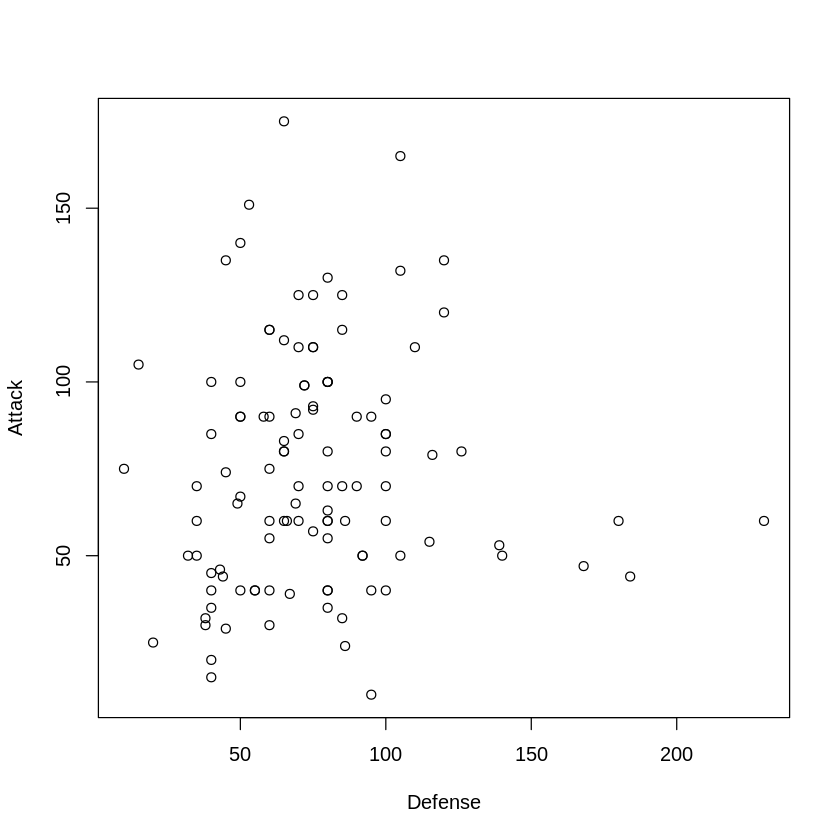

In [2]:
x_plot_values <- X
y_plot_values <- Y

plot(x_plot_values, y_plot_values, xlab = "Defense", ylab= "Attack")

###2. Для заданной выборки построим уравнения средней квадратичной регрессии 𝑥 на 𝑦 и 𝑦 на 𝑥 соответственно.

Для поиска коэффициента корреляции рассчитаем коэффициент ковариации

In [3]:
n <- sample_cardinality
cov <- sum((X - x_mean) * (Y - y_mean)) / n
sprintf("Коэффициент ковариации = %f ", cov)

[1] "Коэффициент ковариации = 43.009009 "

Найдём коэффициент корреляции

In [4]:
r <- cov  / (x_std * y_std)
sprintf("Коэффициент корреляции = %f ", r)

[1] "Коэффициент корреляции = 0.037787 "

Уравнение линейной регрессии $Y$ на $X$

In [5]:
k_yx <- r * y_std / x_std
b_yx <- y_mean - k_yx * x_mean
sprintf("y_x = %fx + %f", k_yx, b_yx)

[1] "y_x = 0.037426x + 71.508162"

Это означает, что с увеличением параметра $x$ на 1 единицу параметр $y$ увеличивается в среднем на 0.0374

Уравнение линейной регрессии $X$ на $Y$


[1] "x_y = 0.038150y + 72.650648"

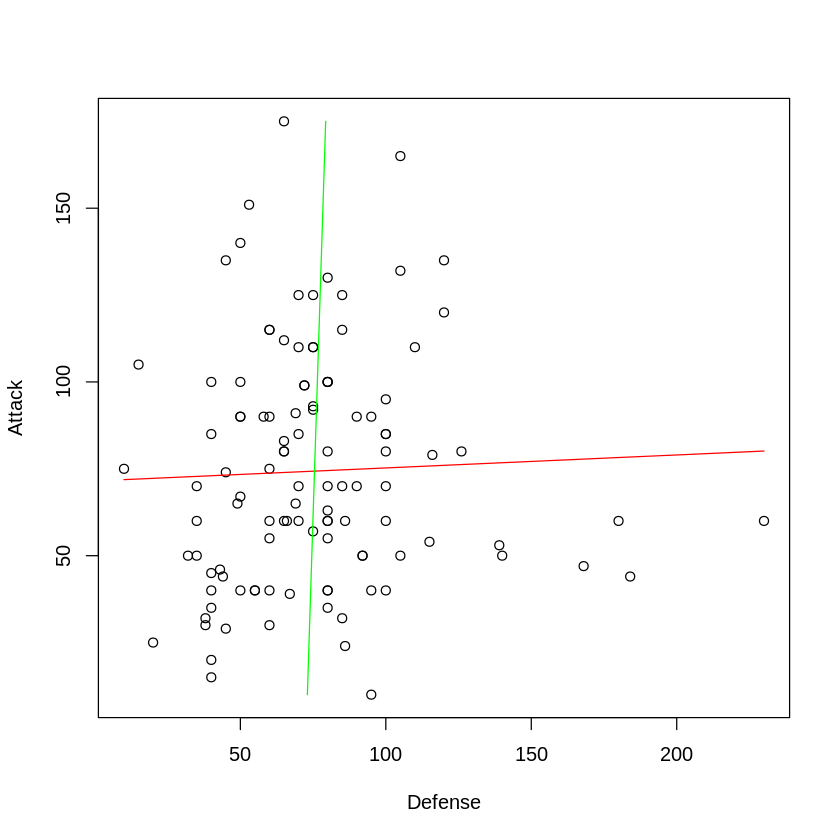

In [6]:
k_xy <- r * x_std / y_std
b_xy <- x_mean - k_xy * y_mean
sprintf("x_y = %fy + %f", k_xy, b_xy)

plot(x_plot_values, y_plot_values, xlab = "Defense", ylab= "Attack")
lines(x_plot_values, k_yx * x_plot_values + b_yx, col="red")
lines(k_xy * y_plot_values + b_xy, y_plot_values, col="green")

Это означает, что с увеличением параметра $y$ на 1 единицу параметр $x$ увеличивается в среднем на 0.0381

###3. Составим корреляционную таблицу для нахождения выборочного корреляционного отношения.

In [7]:
# 3. Построим корреляционную таблицу
##Найдём пары элементов (xi, yj). Возьмём центры соотв. интервалов
x_intervals <- x_interval_series$intervals
y_intervals <- y_interval_series$intervals


correlation_table <- matrix(0, nrow = number_of_intervals, ncol = number_of_intervals)
for (i in 1:number_of_intervals){
  for (j in 1:number_of_intervals){
    for (k in 1:sample_cardinality){
      if ((X[k] > x_intervals[[i]][1] && X[k] <= x_intervals[[i]][2]) && (Y[k] > y_intervals[[j]][1] && Y[k] <= y_intervals[[j]][2])){
        correlation_table[i,j] = correlation_table[i,j] + 1
      }
    }
  }
}

rownames(correlation_table) <- x_centers
colnames(correlation_table) <- y_centers
correlation_table

#Для проверки один из способов нахождения коэффициента корреляции
intergroup_mean <- sum(X * Y)/n 
r_new <- (intergroup_mean - x_mean * y_mean) / (x_std * y_std)
# r_new
# r

,19,43,67,91,115,139,163
22,1,2,3,0,1,0,0
54,5,12,8,11,3,3,1
86,2,9,12,15,7,1,0
118,0,2,1,1,2,2,1
150,0,2,0,0,0,0,0
182,0,2,1,0,0,0,0
214,0,0,1,0,0,0,0


Найдём групповые средние

In [8]:
x_group_means <- 0
y_group_means <- 0
for (i in 1:number_of_intervals){
  x_group_means[i] <- sum(x_centers * correlation_table[i,])/sum(correlation_table[i,])
  y_group_means[i] <- sum(y_centers * correlation_table[, i])/sum(correlation_table[, i])
}
print('X group means') 
x_group_means
print('Y group means') 
y_group_means

[1] "X group means"


[1]  76.85714  91.95349  99.21739 132.22222  54.00000  64.66667  86.00000

[1] "Y group means"


[1] 46.00000 63.68966 61.46154 58.11111 61.46154 63.00000 67.00000

Найдем межгрупповые дисперсии

In [9]:
intergroup_dispersion_x <- 0
intergroup_dispersion_y <- 0
for (i in 1:number_of_intervals){
  intergroup_dispersion_x = intergroup_dispersion_x + (x_group_means[i] - x_mean) * sum(correlation_table[, i])
  intergroup_dispersion_y = intergroup_dispersion_y + (x_group_means[i] - y_mean) * sum(correlation_table[i, ])
}
intergroup_dispersion_x = intergroup_dispersion_x / sample_cardinality
intergroup_dispersion_y = intergroup_dispersion_y / sample_cardinality
intergroup_dispersion_x
intergroup_dispersion_y

[1] 20.84829

[1] 21.46847

Рассчитаем $η_{yx}$ и $η_{xy}$. Убедимся, что неравенства $𝜂_{𝑥𝑦} \geqslant |𝑟_{𝑥𝑦}|$ и $𝜂_{𝑦𝑥} \geqslant |𝑟_{𝑥𝑦}|$ выполняются.


In [10]:
eta_yx = sqrt(intergroup_dispersion_y) / y_std
eta_xy = sqrt(intergroup_dispersion_x) / x_std
eta_yx
eta_xy
print(eta_yx >= r)
print(eta_xy >= r)

[1] 0.137997

[1] 0.1346925

[1] TRUE
[1] TRUE


###4. Построим корреляционную кривую параболического вида $𝑦 = 𝑎𝑥^2 + 𝑏𝑥 + c$.

Представим следующую систему уравнений в матричном виде:

$a \sum x_i^4 + b \sum x_i^3 + c \sum x_i^2 = \sum y_i x_i^2$
<br>
$a \sum x_i^3 + b \sum x_i^2 + c \sum x_i = \sum y_i x_i$
<br>
$a \sum x_i^2 + b \sum x_i + c n = \sum y_i$

In [11]:
mat_a1 <- matrix(0, nrow = 3, ncol = 3)
mat_a1[1, 1] = sum(X^4)
mat_a1[1, 2] = sum(X^3)
mat_a1[1, 3] = sum(X^2)
mat_a1[2, 1] = mat_a1[1, 2]
mat_a1[2, 2] = mat_a1[1, 3]
mat_a1[2, 3] = sum(X)
mat_a1[3, 1] = mat_a1[1, 3]
mat_a1[3, 2] = mat_a1[2, 3]
mat_a1[3, 3] = sample_cardinality

mat_b1 <- matrix(c( sum(Y * X^2), sum(Y * X), sum(Y)), nrow=3)



Решив эту систему, находим коэффициенты параболической регрессии:

In [12]:
parabolic_factors <- solve(mat_a1, mat_b1) 
parabolic_factors

-0.002968705
0.634795570
46.742694630


Построим график получившейся функции

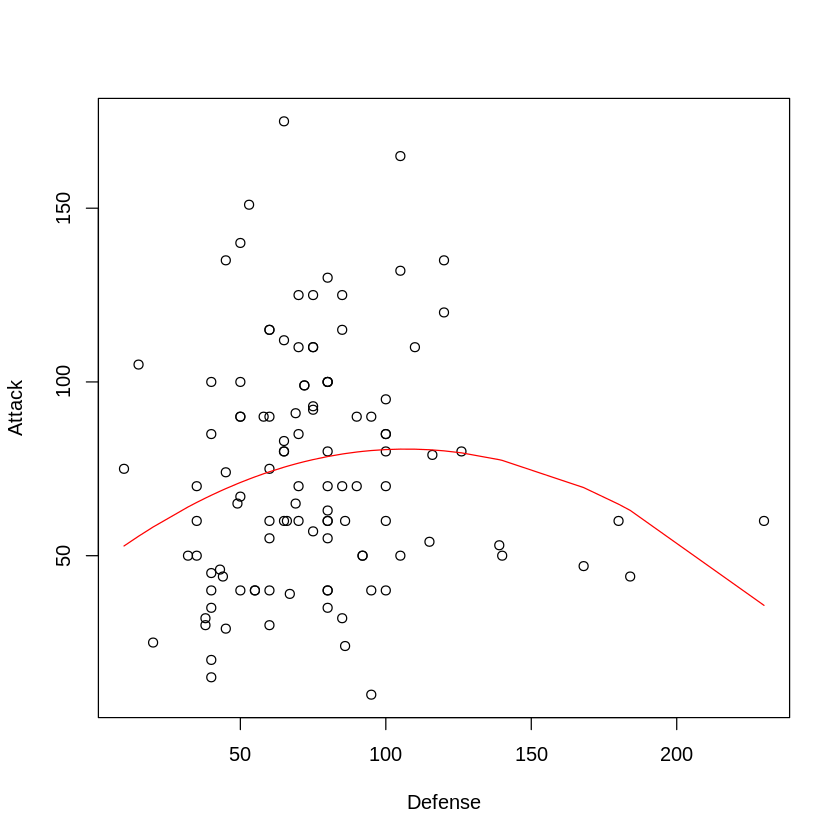

In [13]:
plot(x_plot_values, y_plot_values, xlab = "Defense", ylab= "Attack")
lines(sort(x_plot_values), parabolic_factors[1,1] * sort(x_plot_values)^2 + parabolic_factors[2,1] * sort(x_plot_values) + parabolic_factors[3,1], col="red")

### 5. Для заданной выборки построим следующую нелинейную корреляционную кривую с помощью МНК:
$ y = a * exp(bx) $
<br>
<br>
Прологарифмируем равенство:
<br>
$ln(y) = ln(a) + bx $
<br>
Теперь можно найти коэффициенты $a$ и $b$ по известным формулам для линейной функции:
<br>
$ b = \frac { n \sum x_i ln(y_i) -  \sum x_i \sum ln(y_i) }{n \sum (x_i)^2 - (\sum x_i)^2} $; 
$ a = exp(\frac {1}{n}(\sum ln(y_i) - b \sum x_i))$

In [14]:
exp_b <- (n * sum(X*log(Y)) - sum(X) * sum(log(Y))) / (n * sum(X^2) - (sum(X))^2)
exp_a <- exp((sum(log(Y)) - exp_b * sum(X))/n)

exp_b
exp_a

[1] 0.001081993

[1] 61.04851

Построим график

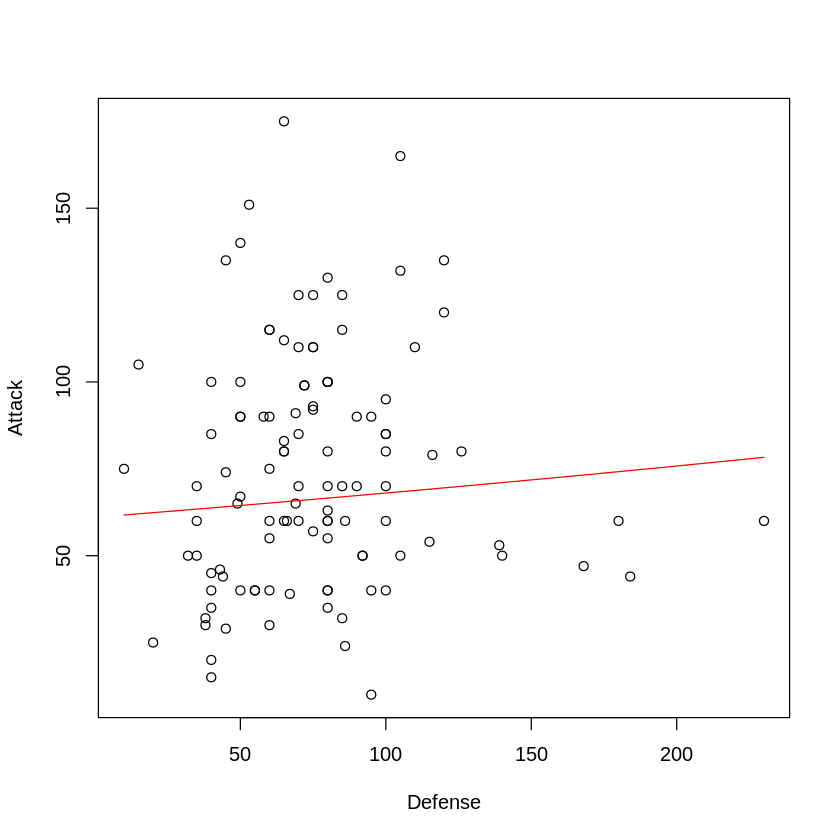

In [15]:
X_exp_vals <- sort(X)
Y_exp_vals <- exp_a * exp(exp_b * X_exp_vals)

plot(x_plot_values, y_plot_values, xlab = "Defense", ylab= "Attack")
lines(X_exp_vals, Y_exp_vals, col="red")

###6.

Вычислим следующие показатели качества регрессии для каждой
кривой:
* теоретический коэффициент детерминации $R^2$;
* средняя квадратическая ошибка $𝑆_𝜀$;
* средняя ошибка аппроксимации (приближения) $A$;

In [16]:
Y_from_linear <-  k_yx * X + b_yx
Y_from_parabolic <- parabolic_factors[1,1] * X^2 + parabolic_factors[2,1] * X + parabolic_factors[3,1]
Y_from_non_linear <- exp_a * exp(exp_b * X)


linear_remainders <- Y - Y_from_linear
parabolic_remainders <- Y - Y_from_parabolic
non_linear_remainders <- Y - Y_from_non_linear


#Коэффициенты детерминации
R_linear <- sum((Y_from_linear - y_mean)^2) / sum((Y - y_mean)^2)
R_parabolic <- sum((Y_from_parabolic - y_mean)^2) / sum((Y - y_mean)^2)
R_non_linear <- sum((Y_from_non_linear - y_mean)^2) / sum((Y - y_mean)^2)
sprintf("Теор. коэффициент детерминации линейной кривой по общей формуле: %f", R_linear)
sprintf("Теор. коэффициент детерминации линейной кривой = r^2(для проверки): %f", r^2)
sprintf("Теор. коэффициент детерминации параболической кривой: %f", R_parabolic)
sprintf("Теор. коэффициент детерминации нелинейной кривой: %f", R_non_linear)

R_linear == r^2 # проверка 

#Средние квадратичные ошибки
S_linear <- sqrt(sum(linear_remainders^2)/(n-2))
S_parabolic <- sqrt(sum(parabolic_remainders^2)/(n-3))
S_non_linear <- sqrt(sum(non_linear_remainders^2)/(n-2))
sprintf("Средняя квадратичная ошибка линейной кривой: %f", S_linear)
S_linear < y_std
sprintf("Средняя квадратичная ошибка параболической кривой: %f", S_parabolic)
S_parabolic < y_std
sprintf("Средняя квадратичная ошибка нелинейной кривой: %f", S_non_linear)
S_non_linear < y_std

#Средние ошибки апроксимации
A_linear <- sum(abs(linear_remainders / Y)) / n * 100
A_parabolic <- sum(abs(parabolic_remainders / Y)) / n * 100
A_non_linear <- sum(abs(non_linear_remainders / Y)) / n * 100
sprintf("Средняя ошибка апроксимации линейной кривой: %f", A_linear)
sprintf("Средняя ошибка апроксимации параболической кривой: %f", A_parabolic)
sprintf("Средняя ошибка апроксимации нелинейной кривой: %f", A_non_linear)


[1] "Теор. коэффициент детерминации линейной кривой по общей формуле: 0.001428"

[1] "Теор. коэффициент детерминации линейной кривой = r^2(для проверки): 0.001428"

[1] "Теор. коэффициент детерминации параболической кривой: 0.041537"

[1] "Теор. коэффициент детерминации нелинейной кривой: 0.062946"

[1] TRUE

[1] "Средняя квадратичная ошибка линейной кривой: 33.858583"

[1] FALSE

[1] "Средняя квадратичная ошибка параболической кривой: 33.324842"

[1] TRUE

[1] "Средняя квадратичная ошибка нелинейной кривой: 34.858148"

[1] FALSE

[1] "Средняя ошибка апроксимации линейной кривой: 53.855882"

[1] "Средняя ошибка апроксимации параболической кривой: 52.643270"

[1] "Средняя ошибка апроксимации нелинейной кривой: 47.976109"

###Интерпретация результатов

Значения коэффициентов детерминации для всех кривых крайне малы(меньше 50%). Это означает, что связь результативного признака $Y$ с исследуемым фактором $X$ практически отсутствует.
<br>
Средняя квадратичная ошибка параболической кривой меньше среднего квадратичного отклонения. Значит, использование этой модели является целесообразным.
<br>
Средняя ошибка апроксимации для всех кривых приняло значение около 50%. Это говорит о том, что рассеяние эмпирических точек довольно велико и качество моделей не является хорошим.

## Выводы
В ходе проделанной работы был изучен и применён метод наименьших квадратов, обоснованы статистические свойства оценок, получаемых с помощью МНК.
Были построены и отображены на графике кривые линейной, параболической и показательной регрессии с использованием метода наименьших квадратов. Построена корреляционная таблица, найдены соответствующие корреляционные отношения. 
Был проведён анализ качества регрессии для каждой кривой через коэффициент детерминации, среднюю квадратическую ошибку, среднюю ошибку апроксимации.